## IMPORTS

In [1]:
import tensorflow as tf
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import cv2
import os

In [2]:
from functions_phase_2 import load_labels 
from functions_phase_2 import dataframe_generator
from functions_phase_2 import index_generator
from functions_phase_2 import train_index_updater
from functions_phase_2 import valid_index_updater
from functions_phase_2 import data_constructor

## SETTING UP PARAMETERS AND DIRECTORIES

In [3]:
SEED = 32
IMG_HEIGHT = 128
IMG_WIDTH = 128
DIM = (IMG_HEIGHT, IMG_WIDTH)
TRAIN_SET= 143778
VALID_SET= 25486
EPOCHS = 15
BS = 32
LR = 0.01
label_file_train = "C:\project\data\\train_COVIDx_CT-2A.txt"
label_file_valid = "C:\project\data\\val_COVIDx_CT-2A.txt"

## LOADING DATA

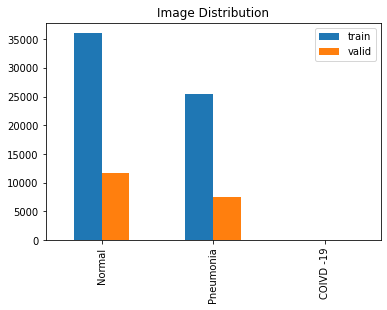

In [4]:
fnames_train , classes_train ,bboxes_train = load_labels(label_file_train)
fnames_valid , classes_valid ,bboxes_valid = load_labels(label_file_valid)
train_index = index_generator(fnames_train , TRAIN_SET)
valid_index = index_generator(fnames_valid , VALID_SET)
train_index_updated = train_index_updater(classes_train,train_index )
valid_index_updated = valid_index_updater(classes_valid, valid_index)
df = dataframe_generator(train_index_updated , valid_index_updated , classes_train , classes_valid)
df.plot.bar( title = "Image Distribution" );

## Loading Training and Validation Images

In [5]:
x_train, y_train = data_constructor(fnames_train,classes_train, DIM , index  =train_index_updated , bboxes = bboxes_train )
x_valid , y_valid= data_constructor(fnames_valid,classes_valid, DIM , index  =valid_index_updated , bboxes = bboxes_valid )

## Pre-Processing

In [6]:
x_train = tf.keras.applications.inception_v3.preprocess_input(x_train)
x_valid = tf.keras.applications.inception_v3.preprocess_input(x_valid)

In [7]:
data_generator = tf.keras.preprocessing.image.ImageDataGenerator(horizontal_flip=True,zoom_range=0.1,width_shift_range=0.1 ,height_shift_range=0.05,shear_range=0.05)
train_generator = data_generator.flow(x_train, y_train, BS)
spe = x_train.shape[0] // BS

## MODEL DESIGN

In [8]:
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.layers import GlobalAveragePooling2D
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dropout

In [9]:
base_model = InceptionV3(include_top=False,weights="imagenet",input_shape=(IMG_HEIGHT,IMG_HEIGHT,3))
model= tf.keras.Sequential()
model.add(base_model) 
model.add(GlobalAveragePooling2D())
model.add(Dense(128,activation=('relu'))) 
model.add(Dropout(.2))
model.add(Dense(1,activation=('sigmoid')))

## MODEL SUMMARY

In [10]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inception_v3 (Model)         (None, 2, 2, 2048)        21802784  
_________________________________________________________________
global_average_pooling2d (Gl (None, 2048)              0         
_________________________________________________________________
dense (Dense)                (None, 128)               262272    
_________________________________________________________________
dropout (Dropout)            (None, 128)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 129       
Total params: 22,065,185
Trainable params: 22,030,753
Non-trainable params: 34,432
_________________________________________________________________


## MODEL COMPILATION

In [11]:
model.compile(optimizer=tf.keras.optimizers.SGD(LR),
              loss = "binary_crossentropy",
              metrics = ["accuracy"])

## CALLBACKS

In [12]:
from tensorflow.keras.callbacks import ModelCheckpoint
modelsdir = "models"
checkpoint = ModelCheckpoint(filepath = modelsdir + "/SGD.{epoch:02d}-{val_accuracy:.4f}.h5" ,
                             monitor= "val_accuracy" , 
                             mode = "max",
                            verbose = 0,
                            save_best_only=True)

## MODEL TRAINING

In [13]:
r = model.fit(train_generator , validation_data=(x_valid, y_valid), steps_per_epoch = spe ,epochs=EPOCHS, callbacks = [checkpoint] )

  ...
    to  
  ['...']
Train for 1924 steps, validate on 19711 samples
Epoch 1/15
1924/1924 [==============================] - 297s 154ms/step - loss: 0.0697 - accuracy: 0.9762 - val_loss: 0.0174 - val_accuracy: 0.9941
Epoch 2/15
1924/1924 [==============================] - 284s 148ms/step - loss: 0.0180 - accuracy: 0.9942 - val_loss: 0.0139 - val_accuracy: 0.9950
Epoch 3/15
1924/1924 [==============================] - 283s 147ms/step - loss: 0.0100 - accuracy: 0.9969 - val_loss: 0.0144 - val_accuracy: 0.9951
Epoch 4/15
1924/1924 [==============================] - 285s 148ms/step - loss: 0.0068 - accuracy: 0.9979 - val_loss: 0.0052 - val_accuracy: 0.9982
Epoch 5/15
1924/1924 [==============================] - 290s 151ms/step - loss: 0.0056 - accuracy: 0.9983 - val_loss: 0.0062 - val_accuracy: 0.9982
Epoch 6/15
1924/1924 [==============================] - 286s 149ms/step - loss: 0.0045 - accuracy: 0.9986 - val_loss: 0.0058 - val_accuracy: 0.9983
Epoch 7/15
1924/1924 [=================

## TRAINING PLOTS

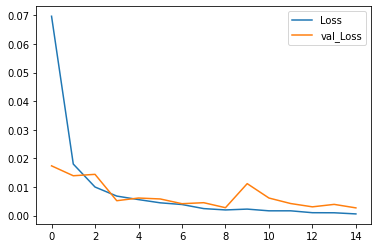

In [14]:
plt.plot(r.history["loss"], label= "Loss")
plt.plot(r.history["val_loss"], label = "val_Loss")
plt.legend();

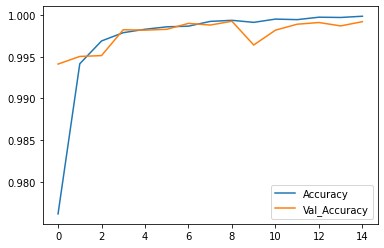

In [15]:
plt.plot(r.history["accuracy"] ,label = "Accuracy")
plt.plot(r.history["val_accuracy"] ,label = "Val_Accuracy")
plt.legend();

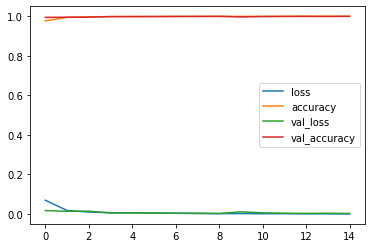

In [16]:
pd.DataFrame(r.history).plot();

In [17]:
pd.DataFrame(r.history).to_csv("csv/inception.csv",index=False)

## SAVING TRAINED MODEL

In [18]:
model.save("models/Inception.h5")